# Simulation de MC

Optimisation d'un pf en maximisant le sharpe ratio par des simulations de monte carlo.

In [22]:
from sys import path
path.append("../")
from useful.getAssets import CC_DATABASE_INTERFACE
cryptocurrency_db = CC_DATABASE_INTERFACE()

In [23]:
import pandas as pd
ASSETS = ["MC","RACE","TTE","SHOP","NVDA","NKE"] # asset's list used in the program
PERIOD = ("2023-01-01","2023-11-01")
assetsData =[]
assetsPrices = pd.DataFrame()
for asset in ASSETS:
    assetData = cryptocurrency_db.getAssetData(asset,*PERIOD)
    assetDf = pd.DataFrame(assetData)
    assetDf = assetDf.set_index("date")
    assetDf = assetDf.set_index(pd.DatetimeIndex(assetDf.index))
    
    assetsPrices[asset] = assetDf["close"]
    assetsData.append(assetDf)

assets_returns = assetsPrices.pct_change().dropna()
returns_cov_matrix = assets_returns.cov()

In [24]:
import random
import numpy as np

def generateWeightsOld(n):
    nombres = [0]
    for _ in range(n-1):
        nombres.append(random.uniform(0, 1-sum(nombres)))
    nombres.append(1-sum(nombres))
    return nombres[1:]

def generateWeights(n):
    weights = np.random.random(n)
    weights /= np.sum(weights)
    return weights


In [29]:
import numpy as np

def portfolio_perfs(w,assets_returns,freq=252,compound=True):
    """
    Args:
        assets_returns (df): daily returns
    """
    # on annualise
    if compound:
        expected_returns = (assets_returns+1).prod() ** (freq/assets_returns.count()) -1
    else:
        expected_returns = assets_returns.mean()*252
    
    pf_variance = np.transpose(w)@(returns_cov_matrix*freq)@w
    pf_risk = np.sqrt(pf_variance)
    
    pf_expected_return = w @ expected_returns
    pf_sharpe = pf_expected_return/pf_risk
    
    
    return {"w":w,"exp_returns":pf_expected_return,"risk":pf_risk,"sharpe":pf_sharpe}

# portfolio_perfs(weights,assets_returns)

In [32]:
generated_weights = []
generated_portfolios = []

nbIteration = 5000
for iteration in range(nbIteration):
    randomWeights = generateWeights(len(ASSETS))
    generated_weights.append(randomWeights)
    
    performances = portfolio_perfs(randomWeights,assets_returns,compound=False)
    generated_portfolios.append(performances)

best_pf = max(generated_portfolios,key = lambda x:x["sharpe"])

Text(0.5, 1.0, 'generation of the effiency frontier - 5000 iterations')

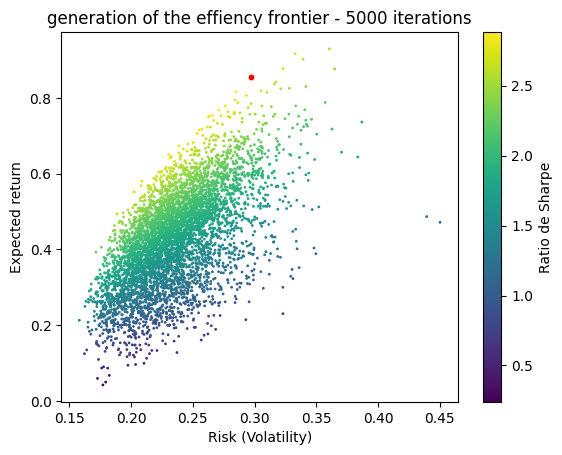

In [33]:
import matplotlib.pyplot as plt
df = pd.DataFrame(generated_portfolios)
plt.scatter(df["risk"],df["exp_returns"],c=df["sharpe"],s=1)
plt.colorbar(label="Ratio de Sharpe")
plt.scatter(best_pf["risk"],best_pf["exp_returns"],s=10,c="red")
plt.xlabel("Risk (Volatility)")
plt.ylabel("Expected return")
plt.title("generation of the effiency frontier - "+str(nbIteration)+" iterations")

In [35]:
best_pf
portfolio_perfs(best_pf["w"],assets_returns)

{'w': array([0.12197232, 0.27502583, 0.08166777, 0.01149628, 0.48835512,
        0.02148268]),
 'exp_returns': 1.4840116422041596,
 'risk': 0.2968767523089345,
 'sharpe': 4.998746552777815}

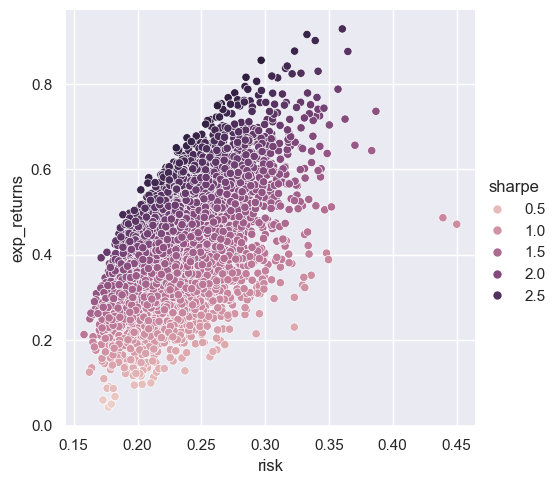

In [42]:
import seaborn as sns
sns.set_theme()
sns.relplot(data=df,x="risk",y="exp_returns",hue="sharpe")
# sns.colorbar(label="Ratio de Sharpe")
# sns.relplot(best_pf["risk"],best_pf["exp_returns"],s=10,c="red")
# sns.xlabel("Risk (Volatility)")
# sns.ylabel("Expected return")
# sns.title("generation of the effiency frontier - "+str(nbIteration)+" iterations")